In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import MinMaxScaler


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import multimodal_vae
import torch_mvae_util as U
import util.RAVDESS_dataset_util as Rd
from train_mvae import build_model, train
from config_args import ConfigModelArgs, ConfigTrainArgs

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
au_dataset = pd.read_csv(cfg_model.dataset_path).to_numpy()

In [6]:
au = au_dataset[:,:-1]
#caler = MinMaxScaler(feature_range=(0, 1))
#au = scaler.fit_transform(au)
emotions = au_dataset[:,-1].astype(int)-1
au_dataset = [(x, y) for x, y in zip(au, emotions)]

In [7]:
trainingset_len = len(au_dataset) // 100 * 70
testset_len = len(au_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    au_dataset, 
    [trainingset_len, testset_len],
    generator=torch.Generator().manual_seed(66)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=False, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  6930 
test set size:  2972


In [8]:
use_cuda = True

model_args = {
    'cat_dim' : cfg_model.cat_dim,
    'au_dim' : cfg_model.au_dim,
    'latent_space_dim' : cfg_model.z_dim,
    'hidden_dim' : cfg_model.hidden_dim,
    'num_filters' : cfg_model.num_filters,
    'modes' : cfg_model.modes,
    'au_weight': cfg_model.au_weight,
    'emotion_weight': cfg_model.emotion_weight,
    'expert_type' : cfg_model.expert_type,
    'use_cuda' : cfg_train.use_cuda
}
print(model_args)
train_args = {
    'learning_rate' : cfg_train.learning_rate,
    'betas' : cfg_train.static_annealing_beta,
    'optim_betas' : cfg_train.optim_betas,
    'num_epochs' : cfg_train.num_epochs,
    'batch_size' : cfg_train.batch_size
}
print(train_args)

{'cat_dim': 8, 'au_dim': 18, 'latent_space_dim': 25, 'hidden_dim': 128, 'num_filters': 32, 'modes': {'au': True, 'face': None, 'emotion': True}, 'au_weight': 10, 'emotion_weight': 0.001, 'expert_type': 'poe', 'use_cuda': True}
{'learning_rate': 0.0001, 'betas': 1e-06, 'optim_betas': [0.95, 0.98], 'num_epochs': 50, 'batch_size': 256}


In [12]:
load_model = True

if load_model:    
    PATH = "../trained_models/au-emo-poe-L2_21-92.save"
    loaded_data = torch.load(PATH)
    model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    model.load_state_dict(loaded_data['model_state'])
      
    model.eval()
else:
    model: torch.nn.Module = build_model(**model_args).double()

In [13]:
train_model = False

if train_model:
    training_losses = train(
        mvae_model=model,
        dataset_loader=dataset_loader,
        learning_rate=cfg_train.learning_rate,
        optim_betas=cfg_train.optim_betas,
        num_epochs=cfg_train.num_epochs,
        seed=cfg_train.seed,
        use_cuda=cfg_train.use_cuda,
        cfg=cfg_train,
        checkpoint_every=cfg_train.checkpoint_every,
        resume_train = False
    )

In [14]:
if train_model: U.print_losses(training_losses)

In [15]:
save_model = False

if save_model:
    PATH = "../trained_models/au-emo-poe-L2_.save"
    torch.save({'model_args' : model_args,
                'train_args': train_args,
                'model_state' : model.state_dict()
               }, PATH)

In [16]:
labels = list(Rd.emocat.values())

In [17]:
print('reg loss train: ' + str(U.au_to_au(model, dataset_loader).item()))
print('reg loss test: ' + str(U.au_to_au(model, testset_loader).item()))

reg loss train: 0.00011069903212110503
reg loss test: 0.00011004152717898902


100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 99.17it/s]


              precision    recall  f1-score   support

     neutral       0.36      0.42      0.39       447
        calm       0.64      0.61      0.62       930
       happy       0.71      0.77      0.74       927
         sad       0.46      0.49      0.48       944
       angry       0.45      0.44      0.45       939
     fearful       0.52      0.49      0.50       917
     disgust       0.69      0.69      0.69       916
   surprised       0.42      0.37      0.40       910

    accuracy                           0.54      6930
   macro avg       0.53      0.54      0.53      6930
weighted avg       0.54      0.54      0.54      6930



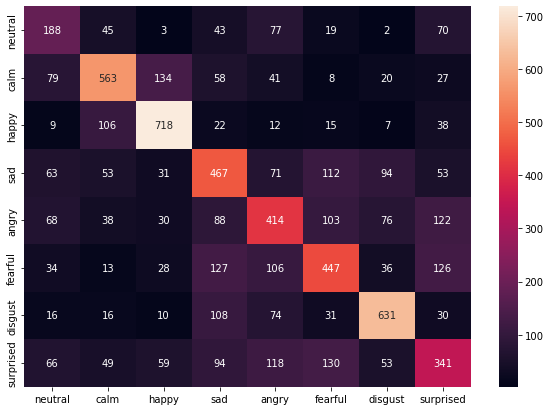

In [18]:
y_true, y_pred = U.au_classiffication_accuracy(model, dataset_loader)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 50.93it/s]


              precision    recall  f1-score   support

     neutral       0.38      0.40      0.39       198
        calm       0.65      0.59      0.62       403
       happy       0.69      0.79      0.74       397
         sad       0.43      0.50      0.46       385
       angry       0.39      0.37      0.38       399
     fearful       0.51      0.46      0.48       384
     disgust       0.73      0.72      0.72       427
   surprised       0.47      0.44      0.46       379

    accuracy                           0.55      2972
   macro avg       0.53      0.53      0.53      2972
weighted avg       0.54      0.55      0.54      2972



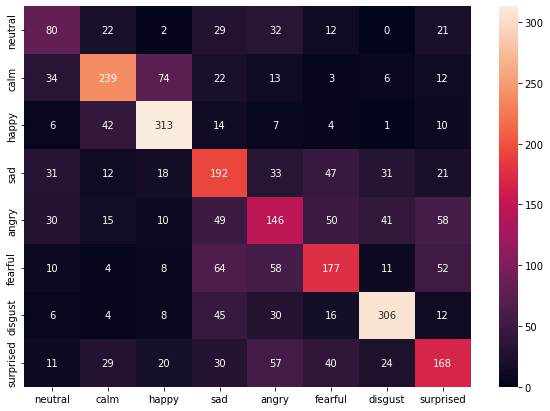

In [19]:
y_true, y_pred = U.au_classiffication_accuracy(model, testset_loader)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

100%|██████████████████████████████████████| 2048/2048 [00:06<00:00, 297.73it/s]


              precision    recall  f1-score   support

     neutral       0.99      0.98      0.99      4123
        calm       0.82      0.95      0.88      4105
       happy       0.92      0.80      0.86      4045
         sad       0.91      1.00      0.95      4114
       angry       0.91      0.85      0.88      4112
     fearful       0.91      0.99      0.95      4106
     disgust       0.99      0.87      0.92      4090
   surprised       0.98      0.95      0.97      4073

    accuracy                           0.92     32768
   macro avg       0.93      0.92      0.92     32768
weighted avg       0.93      0.92      0.92     32768



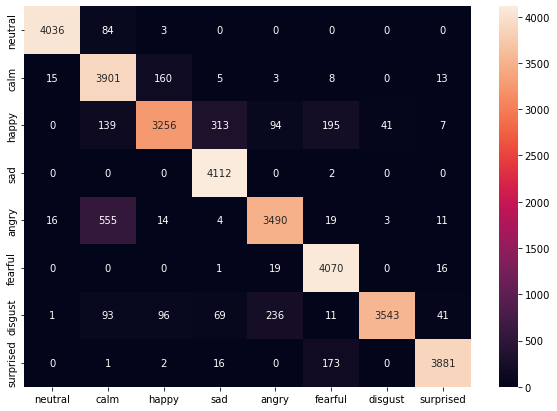

In [20]:
y_true, y_pred = U.au_recon_and_classiffication_accuracy(model, num_samples=2048)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)

In [21]:
Rd.emocat

{0: 'neutral',
 1: 'calm',
 2: 'happy',
 3: 'sad',
 4: 'angry',
 5: 'fearful',
 6: 'disgust',
 7: 'surprised'}

In [22]:
emo_samples = []
emos = torch.tensor([0,1,2,3,4,5,6,7]).cuda()

r_au, _, _, _, _ = model(au=None, emotions=emos)
r_au.cpu()
r_au = torch.clamp(r_au, min=0, max=1)
#r_au *= 5
r_au = r_au.round()

In [23]:
idx = 3
print(Rd.emocat[idx])
print([round(x, 2)for x in r_au[idx].tolist()])

sad
[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]
